In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from PIL import Image
import numpy as np
import os

plt.ion()   # interactive mode

749 749


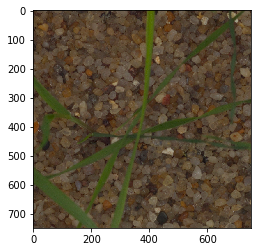

In [2]:
with Image.open('/home/deepanshu/foo/plant/train/Black-grass/ea498dd9c.png') as img:
    width, height = img.size
    print(width, height)
    plt.figure()
    plt.imshow(img) 
    plt.show()

## Load images

In [49]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'plant'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms[x])
                  for x in ['train', 'val']}

num_train = len(image_datasets['train'])
indices = list(range(num_train))
valid_size, shuffle, random_seed, batch_size, num_workers = 0.3, True, 42, 16, 4
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

##########################################################################################################
# Overfitting model
# train_idx, valid_idx = indices[100:300], indices[:10]
##########################################################################################################

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers, sampler=y)
              for x, y in [('train', train_sampler), ('val', valid_sampler)]}

dataset_sizes = {x: y for x, y in [('train', len(train_idx)), ('val', len(valid_idx))]}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [50]:
class_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [4]:
use_gpu = torch.cuda.is_available()

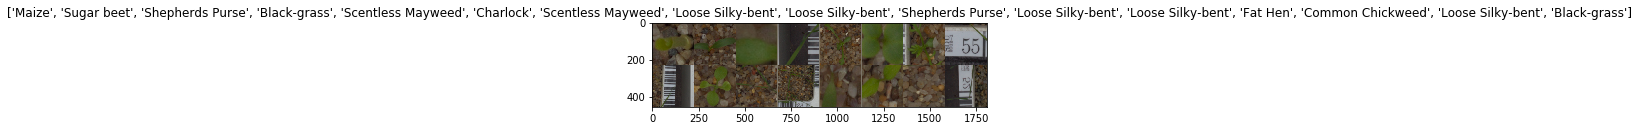

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
train_loss = []
valid_acc = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'val':
                valid_acc.append(epoch_acc)
            else:
                train_loss.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

## Fine tune

In [7]:
def trainable(model, b):
    if isinstance(model, nn.Module):
        model = model.children()
    for m in model:
        if(isinstance(m, nn.Module)):
            trainable(m, b)
        else:
            set_parameters(m, b)
            
def get_block(m, num_layer, b):
    model = None
    if b:
        model = list(m.children())[-num_layer:]
    else:
        model = list(m.children())[:-num_layer]
    trainable(model, b)
    
    
def set_parameters(m, b):
    for i in m.parameters():
        i.requires_grad = True
        

def diff_lr(model_ft):
    params_dict = dict(model_ft.named_parameters())
    lr_rates = []
    for key, value in params_dict.items():
        if key[:6] == 'layer1':
            lr_rates += [{'params':[value], 'lr': 0.000001}]
        elif key[:6] == 'layer2':
            lr_rates += [{'params':[value], 'lr': 0.00001}]
        elif key[:6] == 'layer3':
            lr_rates += [{'params':[value], 'lr': 0.0001}]
        else:
    #         lr_rates += [{'params':[value], 'lr': 0.01}]
            lr_rates += [{'params':[value]}]
    
    return lr_rates

In [8]:
##################################################################
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 12)
###################################################################

model_ft = models.resnet18(pretrained=True)
# get_block(model_ft, 3, False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 12)


if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

ml = diff_lr(model_ft)

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
optimizer_ft = optim.Adam(ml, lr=0.001, eps=1e-8, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[4, 9, 16, 25], gamma=0.1)

Epoch 0/29
----------
train Loss: 0.0668 Acc: 0.6490
val Loss: 0.0295 Acc: 0.8274

Epoch 1/29
----------
train Loss: 0.0419 Acc: 0.7714
val Loss: 0.0249 Acc: 0.8505

Epoch 2/29
----------
train Loss: 0.0367 Acc: 0.7982
val Loss: 0.0197 Acc: 0.8926

Epoch 3/29
----------
train Loss: 0.0313 Acc: 0.8304
val Loss: 0.0273 Acc: 0.8421

Epoch 4/29
----------
train Loss: 0.0246 Acc: 0.8680
val Loss: 0.0120 Acc: 0.9242

Epoch 5/29
----------
train Loss: 0.0207 Acc: 0.8851
val Loss: 0.0110 Acc: 0.9319

Epoch 6/29
----------
train Loss: 0.0185 Acc: 0.8983
val Loss: 0.0104 Acc: 0.9375

Epoch 7/29
----------
train Loss: 0.0177 Acc: 0.9029
val Loss: 0.0099 Acc: 0.9425

Epoch 8/29
----------
train Loss: 0.0174 Acc: 0.9011
val Loss: 0.0098 Acc: 0.9439

Epoch 9/29
----------
train Loss: 0.0160 Acc: 0.9119
val Loss: 0.0091 Acc: 0.9495

Epoch 10/29
----------
train Loss: 0.0150 Acc: 0.9224
val Loss: 0.0093 Acc: 0.9488

Epoch 11/29
----------
train Loss: 0.0161 Acc: 0.9116
val Loss: 0.0092 Acc: 0.9481

Ep

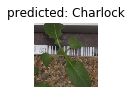

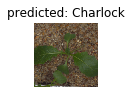

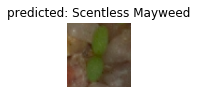

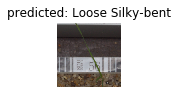

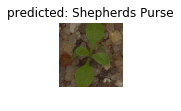

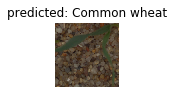

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)
visualize_model(model_ft)

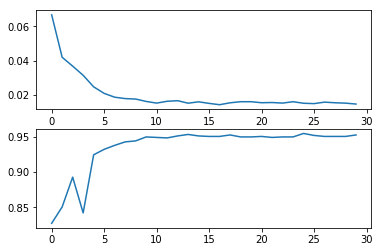

In [10]:
plt.subplot(211)
plt.plot(train_loss)
plt.subplot(212)
plt.plot(valid_acc)
plt.show()

## Continue learning

Epoch 0/34
----------
train Loss: 0.0154 Acc: 0.9137
val Loss: 0.0084 Acc: 0.9572

Epoch 1/34
----------
train Loss: 0.0150 Acc: 0.9146
val Loss: 0.0088 Acc: 0.9467

Epoch 2/34
----------
train Loss: 0.0147 Acc: 0.9188
val Loss: 0.0087 Acc: 0.9586

Epoch 3/34
----------
train Loss: 0.0148 Acc: 0.9209
val Loss: 0.0087 Acc: 0.9523

Epoch 4/34
----------
train Loss: 0.0135 Acc: 0.9302
val Loss: 0.0088 Acc: 0.9467

Epoch 5/34
----------
train Loss: 0.0133 Acc: 0.9287
val Loss: 0.0082 Acc: 0.9565

Epoch 6/34
----------
train Loss: 0.0127 Acc: 0.9380
val Loss: 0.0086 Acc: 0.9488

Epoch 7/34
----------
train Loss: 0.0137 Acc: 0.9260
val Loss: 0.0082 Acc: 0.9537

Epoch 8/34
----------
train Loss: 0.0136 Acc: 0.9293
val Loss: 0.0079 Acc: 0.9579

Epoch 9/34
----------
train Loss: 0.0129 Acc: 0.9320
val Loss: 0.0078 Acc: 0.9593

Epoch 10/34
----------
train Loss: 0.0123 Acc: 0.9402
val Loss: 0.0082 Acc: 0.9593

Epoch 11/34
----------
train Loss: 0.0138 Acc: 0.9287
val Loss: 0.0082 Acc: 0.9551

Ep

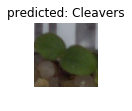

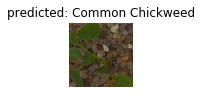

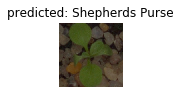

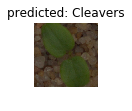

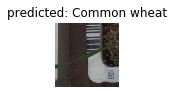

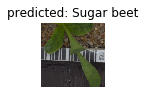

In [11]:
# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001, eps=1e-8, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[7, 18, 29], gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=35)
visualize_model(model_ft)

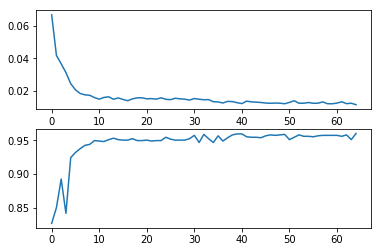

In [12]:
plt.subplot(211)
plt.plot(train_loss)
plt.subplot(212)
plt.plot(valid_acc)
plt.show()

## Save model

In [13]:
import pickle
pickle.dump(model_ft.state_dict(), open('96_0000_res18.pkl', 'wb'))


## Load model

In [ ]:
model_ft_2 = models.resnet18(pretrained=True)
# get_block(model_ft, 3, True)
get_block(model_ft_2, 3, False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs, 12)


if use_gpu:
    model_ft_2 = model_ft_2.cuda()


In [ ]:
var = pickle.load(open('80_res18.pkl', 'rb'))
model_ft_2.load_state_dict(var)

In [ ]:
criterion = nn.CrossEntropyLoss()
running_loss, running_corrects = 0.0, 0.0
phase = 'val'
for data in dataloaders[phase]:
    inputs, labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

    outputs = model_ft_2(inputs)
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)
    
    # statistics
    running_loss += loss.data[0]
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / dataset_sizes[phase]
epoch_acc = running_corrects / dataset_sizes[phase]

print(epoch_loss, epoch_acc)

## ResNet50

In [8]:
##################################################################
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 12)
###################################################################

res_50 = models.resnet50(pretrained=True)
# get_block(model_ft, 3, False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = res_50.fc.in_features
res_50.fc = nn.Linear(num_ftrs, 12)


if use_gpu:
    res_50 = res_50.cuda()

criterion = nn.CrossEntropyLoss()

ml = diff_lr(res_50)

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
optimizer_ft = optim.Adam(ml, lr=0.001, eps=1e-8, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[9, 16, 25], gamma=0.1)

Epoch 0/29
----------
train Loss: 0.0717 Acc: 0.6271
val Loss: 0.0267 Acc: 0.8533

Epoch 1/29
----------
train Loss: 0.0465 Acc: 0.7537
val Loss: 0.0345 Acc: 0.8260

Epoch 2/29
----------
train Loss: 0.0349 Acc: 0.8030
val Loss: 0.0174 Acc: 0.8975

Epoch 3/29
----------
train Loss: 0.0309 Acc: 0.8337
val Loss: 0.0156 Acc: 0.9116

Epoch 4/29
----------
train Loss: 0.0280 Acc: 0.8481
val Loss: 0.0232 Acc: 0.8582

Epoch 5/29
----------
train Loss: 0.0269 Acc: 0.8598
val Loss: 0.0249 Acc: 0.8842

Epoch 6/29
----------
train Loss: 0.0233 Acc: 0.8731
val Loss: 0.0108 Acc: 0.9418

Epoch 7/29
----------
train Loss: 0.0224 Acc: 0.8803
val Loss: 0.0132 Acc: 0.9291

Epoch 8/29
----------
train Loss: 0.0196 Acc: 0.8929
val Loss: 0.0116 Acc: 0.9354

Epoch 9/29
----------
train Loss: 0.0154 Acc: 0.9137
val Loss: 0.0074 Acc: 0.9579

Epoch 10/29
----------
train Loss: 0.0124 Acc: 0.9374
val Loss: 0.0071 Acc: 0.9593

Epoch 11/29
----------
train Loss: 0.0116 Acc: 0.9383
val Loss: 0.0080 Acc: 0.9586

Ep

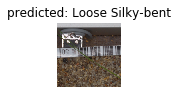

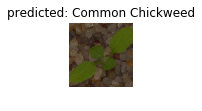

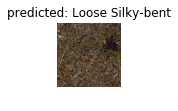

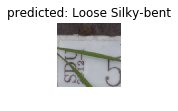

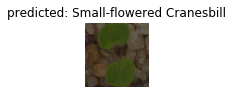

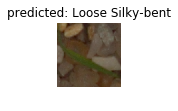

In [9]:
res_50 = train_model(res_50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)
visualize_model(res_50)

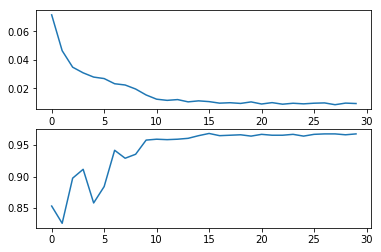

In [10]:
plt.subplot(211)
plt.plot(train_loss)
plt.subplot(212)
plt.plot(valid_acc)
plt.show()

## Save model

In [11]:
import pickle
pickle.dump(res_50.state_dict(), open('96_8421_res50.pkl', 'wb'))


### Train with ensamble

In [21]:
train_loss = []
valid_acc = []
best_model_wts = [None, None, None, None, None]
best_acc = [0.0, 0.0, 0.0, 0.0, 0.0]
def train_model_2(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

#     best_model_wts = model.state_dict()
#     best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'val':
                valid_acc.append(epoch_acc)
            else:
                train_loss.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = model.state_dict()
            if phase == 'val':
                for idx, acc in enumerate(best_acc):
                    if acc < epoch_acc:
                        for i in range(4, idx, -1):
                            best_acc[i] = best_acc[i - 1]
                            best_model_wts[i] = best_model_wts[i - 1]
                        best_acc[idx] = epoch_acc
                        best_model_wts[idx] = model.state_dict()
                        break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## ResNet152

In [22]:
##################################################################
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 12)
###################################################################

res_152 = models.resnet152(pretrained=True)
# get_block(model_ft, 3, False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = res_152.fc.in_features
res_152.fc = nn.Linear(num_ftrs, 12)


if use_gpu:
    res_152 = res_152.cuda()

criterion = nn.CrossEntropyLoss()

ml = diff_lr(res_152)

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
optimizer_ft = optim.Adam(ml, lr=0.001, eps=1e-8, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[9, 16, 25], gamma=0.1)

In [23]:
res_152 = train_model_2(res_152, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)
visualize_model(res_152)

Epoch 0/29
----------
train Loss: 0.0676 Acc: 0.6523


RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:66

In [ ]:
plt.subplot(211)
plt.plot(train_loss)
plt.subplot(212)
plt.plot(valid_acc)
plt.show()

## Save model

In [11]:
import pickle
pickle.dump(res_152.state_dict(), open('97_1228_res152.pkl', 'wb'))


## VGG19_bn

In [8]:
def diff_lr_2(model_ft):
    params_dict = dict(model_ft.named_parameters())
    lr_rates = []
    for key, value in params_dict.items():
        layer_number = -1
        if key[:8] == 'features':
            try:
                layer_number = int(key[9:11])
            except Exception as e:
                layer_number = int(key[9:10])
        if layer_number < 15 and layer_number > -1:
            lr_rates += [{'params':[value], 'lr': 0.000001}]
        elif layer_number < 30 and layer_number > -1:
            lr_rates += [{'params':[value], 'lr': 0.00001}]
        elif layer_number > 30 and layer_number > -1:
            lr_rates += [{'params':[value], 'lr': 0.0001}]
        else:
            lr_rates += [{'params':[value]}]
    
    return lr_rates

In [9]:
model_ft = models.vgg19_bn(pretrained=True)
# num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(1000, 12)

# model_ft.fc = nn.Linear(512, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

ml = diff_lr_2(model_ft)

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
optimizer_ft = optim.Adam(ml, lr=0.001, eps=1e-8, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[9, 16, 25], gamma=0.1)

Epoch 0/29
----------
train Loss: 0.1257 Acc: 0.4069
val Loss: 0.0493 Acc: 0.7340

Epoch 1/29
----------
train Loss: 0.0674 Acc: 0.6692
val Loss: 0.0334 Acc: 0.8302

Epoch 2/29
----------
train Loss: 0.0547 Acc: 0.7245
val Loss: 0.0367 Acc: 0.7902

Epoch 3/29
----------
train Loss: 0.0510 Acc: 0.7552
val Loss: 0.0298 Acc: 0.8428

Epoch 4/29
----------
train Loss: 0.0438 Acc: 0.7862
val Loss: 0.0280 Acc: 0.8639

Epoch 5/29
----------
train Loss: 0.0408 Acc: 0.7955
val Loss: 0.0188 Acc: 0.8891

Epoch 6/29
----------
train Loss: 0.0378 Acc: 0.8081
val Loss: 0.0198 Acc: 0.8898

Epoch 7/29
----------
train Loss: 0.0337 Acc: 0.8274
val Loss: 0.0184 Acc: 0.9130

Epoch 8/29
----------
train Loss: 0.0350 Acc: 0.8295
val Loss: 0.0209 Acc: 0.8912

Epoch 9/29
----------
train Loss: 0.0251 Acc: 0.8680
val Loss: 0.0130 Acc: 0.9305

Epoch 10/29
----------
train Loss: 0.0210 Acc: 0.8902
val Loss: 0.0134 Acc: 0.9340

Epoch 11/29
----------
train Loss: 0.0213 Acc: 0.8935
val Loss: 0.0115 Acc: 0.9382

Ep

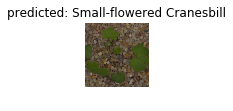

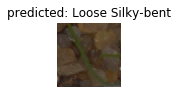

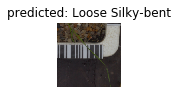

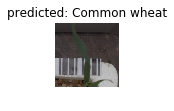

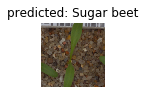

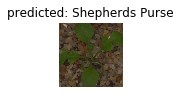

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)
visualize_model(model_ft)

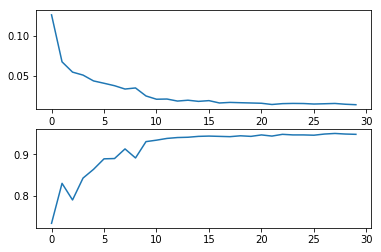

In [11]:
plt.subplot(211)
plt.plot(train_loss)
plt.subplot(212)
plt.plot(valid_acc)
plt.show()

Epoch 0/39
----------
train Loss: 0.0165 Acc: 0.9125
val Loss: 0.0101 Acc: 0.9467

Epoch 1/39
----------
train Loss: 0.0161 Acc: 0.9101
val Loss: 0.0115 Acc: 0.9460

Epoch 2/39
----------
train Loss: 0.0171 Acc: 0.9101
val Loss: 0.0113 Acc: 0.9446

Epoch 3/39
----------
train Loss: 0.0166 Acc: 0.9125
val Loss: 0.0100 Acc: 0.9530

Epoch 4/39
----------
train Loss: 0.0147 Acc: 0.9233
val Loss: 0.0092 Acc: 0.9544

Epoch 5/39
----------
train Loss: 0.0156 Acc: 0.9197
val Loss: 0.0097 Acc: 0.9509

Epoch 6/39
----------
train Loss: 0.0138 Acc: 0.9230
val Loss: 0.0101 Acc: 0.9544

Epoch 7/39
----------
train Loss: 0.0148 Acc: 0.9221
val Loss: 0.0102 Acc: 0.9537

Epoch 8/39
----------
train Loss: 0.0148 Acc: 0.9209
val Loss: 0.0102 Acc: 0.9551

Epoch 9/39
----------
train Loss: 0.0121 Acc: 0.9341
val Loss: 0.0096 Acc: 0.9565

Epoch 10/39
----------
train Loss: 0.0135 Acc: 0.9260
val Loss: 0.0093 Acc: 0.9579

Epoch 11/39
----------
train Loss: 0.0119 Acc: 0.9368
val Loss: 0.0092 Acc: 0.9572

Ep

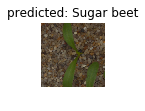

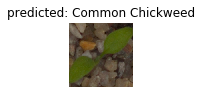

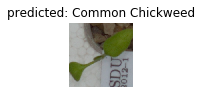

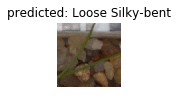

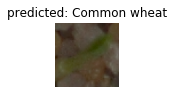

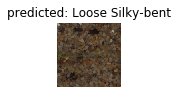

In [12]:
# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001, eps=1e-8, weight_decay=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[7, 18, 29], gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40)
visualize_model(model_ft)

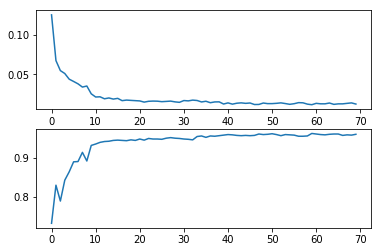

In [15]:
plt.subplot(211)
plt.plot(train_loss)
plt.subplot(212)
plt.plot(valid_acc)
plt.show()

In [14]:
import pickle
pickle.dump(model_ft.state_dict(), open('96_0702_vgg19_nb.pkl', 'wb'))

## Testing

In [5]:
import pickle
# ResNet 18
res_18_test = models.resnet18(pretrained=True)
num_ftrs = res_18_test.fc.in_features
res_18_test.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    res_18_test = res_18_test.cuda()

var = pickle.load(open('96_0000_res18.pkl', 'rb'))
res_18_test.load_state_dict(var)

# ResNet 50
res_50_test = models.resnet50(pretrained=True)
num_ftrs = res_50_test.fc.in_features
res_50_test.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    res_50_test = res_50_test.cuda()

var = pickle.load(open('96_8421_res50.pkl', 'rb'))
res_50_test.load_state_dict(var)

# ResNet 152
res_152_test = models.resnet152(pretrained=True)
num_ftrs = res_152_test.fc.in_features
res_152_test.fc = nn.Linear(num_ftrs, 12)

if use_gpu:
    res_152_test = res_152_test.cuda()

var = pickle.load(open('97_1228_res152.pkl', 'rb'))
res_152_test.load_state_dict(var)

## Create a function to evaluate model

In [5]:
objs = list()
for data in dataloaders['val']:
    objs.append(data)

In [6]:
def foo(model):
    model.eval()
    running_corrects = 0.0
    phase = 'val'
    final = np.zeros(1)
    real_result = np.zeros(1)
    for data in objs:
        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs_res18 = model(inputs)
        _, preds_res18 = torch.max(outputs_res18.data, 1)
        running_corrects += torch.sum(preds_res18 == labels.data)
        final = np.concatenate([final, preds_res18.cpu().numpy()])
        real_result = np.concatenate([real_result, labels.data.cpu().numpy()])

    epoch_acc = running_corrects / dataset_sizes[phase]
    print(epoch_acc)
    return final[1:], real_result[1:]

In [8]:
final_18, res1 = foo(res_18_test)
# print(final_18.shape)
del res_18_test

final_50, res2 = foo(res_50_test)
# print(final_50.shape)
del res_50_test

0.96
0.967719298246


In [9]:
final_152, res3 = foo(res_152_test)
# print(final_152.shape)
# del res_152_test

0.969824561404


In [10]:
print(final_18[:15])
print(final_50[:15])
print(final_152[:15])
print(res1[:15])
print(res2[:15])
print(res3[:15])

[ 10.   9.   0.   2.   5.  11.   8.   9.   5.  11.   2.   9.   3.   4.  11.]
[ 10.   9.   0.   2.   5.  11.   8.   9.   5.  11.   2.   9.   3.   4.  11.]
[ 10.   9.   0.   2.   5.  11.   8.   9.   5.  11.   2.   9.   3.   4.  11.]
[ 10.   9.   0.   2.   5.  11.   8.   9.   5.  11.   2.   9.   3.   4.  11.]
[ 10.   9.   0.   2.   5.  11.   8.   9.   5.  11.   2.   9.   3.   4.  11.]
[ 10.   9.   0.   2.   5.  11.   8.   9.   5.  11.   2.   9.   3.   4.  11.]


### Store lists and results

In [11]:
import pickle
pickle.dump({"final_18": final_18, "final_50": final_50, "final_152": final_152, "res": res3}, open('vars', 'wb'))

### Read stored results and variables

In [12]:
import pickle
var = pickle.load(open('vars', 'rb'))
final_50 = var["final_50"]
final_18 = var["final_18"]
final_152 = var["final_152"]
res3 = var["res"]

In [13]:
for i in range(len(final_18)):
    if final_50[i] != final_152[i] or final_18[i] != final_50[i] or final_18[i] != final_152[i]:
#         print(i, ":", final_18[i], final_50[i], final_152[i], res3[i])
        print("idx:", i, "result:", res3[i], "final_18:", final_18[i], 
              "final_50:", final_50[i], "final_152:", final_152[i])

idx: 53 result: 6.0 final_18: 0.0 final_50: 0.0 final_152: 6.0
idx: 116 result: 0.0 final_18: 6.0 final_50: 0.0 final_152: 6.0
idx: 127 result: 0.0 final_18: 6.0 final_50: 6.0 final_152: 0.0
idx: 172 result: 6.0 final_18: 6.0 final_50: 6.0 final_152: 0.0
idx: 241 result: 5.0 final_18: 0.0 final_50: 5.0 final_152: 0.0
idx: 244 result: 0.0 final_18: 0.0 final_50: 6.0 final_152: 6.0
idx: 255 result: 8.0 final_18: 6.0 final_50: 8.0 final_152: 8.0
idx: 270 result: 6.0 final_18: 6.0 final_50: 6.0 final_152: 0.0
idx: 335 result: 6.0 final_18: 6.0 final_50: 0.0 final_152: 6.0
idx: 350 result: 3.0 final_18: 8.0 final_50: 3.0 final_152: 3.0
idx: 365 result: 6.0 final_18: 6.0 final_50: 0.0 final_152: 6.0
idx: 374 result: 0.0 final_18: 0.0 final_50: 6.0 final_152: 0.0
idx: 378 result: 6.0 final_18: 0.0 final_50: 0.0 final_152: 6.0
idx: 405 result: 0.0 final_18: 6.0 final_50: 6.0 final_152: 0.0
idx: 428 result: 0.0 final_18: 4.0 final_50: 0.0 final_152: 4.0
idx: 485 result: 0.0 final_18: 6.0 final_

In [14]:
d = len(res3)
print(d)
print(sum([1 for i in range(d) if final_18[i] == res3[i]]) * 1.0 / d)
print(sum(final_50 == res3) * 1.0 / d)
print(sum(final_152 == res3) * 1.0 / d)
ensamble = list()
for i in range(d):
    a, b, c = final_18[i], final_50[i], final_152[i]
    if a == b and a == c:
        ensamble.append(a)
    elif b == c:
        ensamble.append(c)
    elif a == b:
        ensamble.append(a)
    else:
        ensamble.append(c)
print(sum(ensamble == res3) * 1.0 / d)

1425
0.96
0.967719298246
0.969824561404
0.968421052632


## Prev Working

In [32]:
criterion = nn.CrossEntropyLoss()
running_loss, running_corrects = 0.0, 0.0
phase = 'val'

for data in dataloaders[phase]:
    inputs, labels = data
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

    outputs_res18 = res_18_test(inputs)
    outputs_res50 = res_50_test(inputs)
    outputs_res152 = res_152_test(inputs)
    
    _, preds_res18 = torch.max(outputs_res18.data, 1)
    _, preds_res50 = torch.max(outputs_res50.data, 1)
    _, preds_res152 = torch.max(outputs_res152.data, 1)
    
    preds_res18 = preds_res18.cpu().numpy()
    preds_res50 = preds_res50.cpu().numpy()
    preds_res152 = preds_res152.cpu().numpy()
    labels = labels.data.cpu().numpy()
    final = list()
    print("Length of preds", len(preds_res152))
    for i in range(len(preds_res152)):
#         a, b, c = preds_res152[i], preds_res50[i], preds_res18[i]
        a, b, c = preds_res152[i], preds_res18[i], preds_res152[i]
        if a == b and a == c:
            final.append(a)
        elif a == b:
            final.append(a)
        elif b == c:
            final.append(b)
        else:
            final.append(a)

    running_corrects += np.sum(np.array(final) == labels)
    print("Length of final", len(final))
    print("Length of labels", len(labels))
    print("Corrects", running_corrects)
    print()
#     running_corrects += torch.sum(preds == labels.data)

epoch_acc = running_corrects / dataset_sizes[phase]
print(dataset_sizes[phase])
print(epoch_acc)

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:66

In [8]:
type(labels.data)
type(preds_res18)

torch.cuda.LongTensor

In [11]:
a = labels.data.cpu().numpy()

In [16]:
b = preds_res18.cpu().numpy()

[11 11  5  6  4  6 10  3  3  9  6 10 10  0  8  6]
[11 11  5  6  4  6 10  3  3  9  0 10 10  0  8  6]
15


## Testing model

In [6]:
import pandas as pd
from torch import np # Torch wrapper for Numpy

import os
from PIL import Image

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.preprocessing import MultiLabelBinarizer

In [21]:
class KaggleAmazonDataset(Dataset):
    """Dataset wrapping images and target labels for Kaggle - Planet Amazon from Space competition.

    Arguments:
        A CSV file path
        Path to image folder
        Extension of images
        PIL transforms
    """

    def __init__(self, csv_path, img_path, img_ext, transform=None):
    
        tmp_df = pd.read_csv(csv_path)
        assert tmp_df['file'].apply(lambda x: os.path.isfile(img_path + x)).all(), \
"Some images referenced in the CSV file were not found"
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        self.X_train = tmp_df['file']
        self.y_train = self.mlb.fit_transform(tmp_df['species'].str.split()).astype(np.float32)

    def __getitem__(self, index):
        img = Image.open(self.img_path + self.X_train[index])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform['test'](img)
        
#         label = torch.from_numpy(self.y_train[index])
        return img, self.X_train[index]

    def __len__(self):
        return len(self.X_train.index)

In [22]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'test': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/home/deepanshu/foo/sample_submission.csv'
IMG_EXT = ''
IMG_PATH = '/home/deepanshu/foo/plant/test/'
dset_train = KaggleAmazonDataset(data_dir, IMG_PATH, IMG_EXT, data_transforms)

dataloaders_1 = {x: torch.utils.data.DataLoader(dset_train, batch_size=16,
                                             shuffle=False, num_workers=4)
              for x in ['test']}

use_gpu = torch.cuda.is_available()

In [23]:
objs = list()
for data in dataloaders_1['test']:
    objs.append(data)

In [45]:
def foo_2(model):
    model.eval()
    phase = 'test'
    final = np.zeros(1)
    names = [0]
    for data in objs:
        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
#             labels = Variable(labels.cuda())
        else:
#             inputs, labels = Variable(inputs), Variable(labels)
            inputs = Variable(inputs)
        for l in labels:
            names.append(l)

        outputs_res18 = model(inputs)
        _, preds_res18 = torch.max(outputs_res18.data, 1)
        final = np.concatenate([final, preds_res18.cpu().numpy()])

    return final[1:], names[1:]

In [46]:
result, names = foo_2(res_152_test)

In [51]:
mapping = {'0': 'Black-grass',
 '1': 'Charlock',
 '2':'Cleavers',
 '3':'Common Chickweed',
 '4':'Common wheat',
 '5':'Fat Hen',
 '6':'Loose Silky-bent',
 '7':'Maize',
 '8':'Scentless Mayweed',
 '9':'Shepherds Purse',
 '10':'Small-flowered Cranesbill',
 '11':'Sugar beet'}

In [55]:
with open('submission.csv', 'w') as f:
    f.write('file,species\n')
    for i in range(len(names)):
        print(str(names[i] + ',' + mapping[str(int(result[i]))] + '\n'), end='')
        f.write(str(names[i] + ',' + mapping[str(int(result[i]))] + '\n'))

0021e90e4.png,Small-flowered Cranesbill
003d61042.png,Fat Hen
007b3da8b.png,Sugar beet
0086a6340.png,Common Chickweed
00c47e980.png,Sugar beet
00d090cde.png,Loose Silky-bent
00ef713a8.png,Common Chickweed
01291174f.png,Fat Hen
026716f9b.png,Loose Silky-bent
02cfeb38d.png,Loose Silky-bent
03566743d.png,Fat Hen
03a2ee656.png,Small-flowered Cranesbill
03e322a29.png,Sugar beet
03ef36742.png,Scentless Mayweed
043449b0b.png,Sugar beet
0437393b1.png,Fat Hen
04814f36d.png,Scentless Mayweed
05341a8a6.png,Scentless Mayweed
060450d79.png,Common Chickweed
060f1dc84.png,Shepherds Purse
0625f063b.png,Common Chickweed
063363305.png,Small-flowered Cranesbill
06d12f6fa.png,Shepherds Purse
071cb3ece.png,Sugar beet
0751c0bbc.png,Sugar beet
07e62f903.png,Maize
085974290.png,Scentless Mayweed
0885e7690.png,Scentless Mayweed
089ad62a7.png,Common Chickweed
08d591441.png,Sugar beet
0911d3dee.png,Common Chickweed
099b961ec.png,Shepherds Purse
0a64e3e6c.png,Black-grass
0ad9e7dfb.png,Sugar beet
0ae6668fa.png,Loo